Creating a Sentence Tokenizer on the version 6 of the corpora
----------------------------------
We added new sentences to extracted sentences from the book <i style="color: cyan">Grammaire de Wolof Moderne</i> by Pathé Diagne plus the original corpora to obtain the sixth version of it.

The process is almost the same as in [processing_4](text_processing4.ipynb) excepted that we will create another custom dataset for the custom transformer model and identify with a box plot the range of the maximum length of the sequences in order to tune the `max_len` parameter provided to the custom dataset.

Let us import the necessary libraries.

In [1]:
# # for creating the tokenizer
from tokenizers import (
    decoders,
#     SentencePieceBPETokenizer,
#     normalizers,
#     pre_tokenizers,
)
# from transformers import AutoTokenizer, PreTrainedTokenizerFast, T5TokenizerFast

import sentencepiece as spm

# for importing and manipulating the sentences
import pandas as pd
import random

# for plotting the box plot of the sequence lengths
import plotly.express as px

# for loading sentences with the custom dataset
from torch.utils.data import DataLoader

#### Load dataset and create generator

We will create one tokenizer for both of the French and Wolof corpora because the `T5` model understand only one embedding layer. So we must create one generator for both of the French and Wolof corpora. 

In [2]:
# load sentences
sentences = pd.read_csv("data/extractions/new_data/corpora_v6.csv")

# initialize a batch size
BATCH_SIZE = 400

# create generators (for the corpora)
# def generate_sents():
    
#     # recuperate the sentences
#     french_sents = sentences['french'].to_list() 
    
#     wolof_sents = sentences['wolof'].to_list() 
    
#     sents = french_sents + wolof_sents
    
#     for i in range(1, len(sents), BATCH_SIZE):
        
#         yield sents[i:i+BATCH_SIZE]

with open('sents.txt', 'w', encoding='utf-8') as f:
    for sent in sentences['french'].to_list() + sentences['wolof'].to_list():
        f.write(sent + '\n')

#### Initialize the tokenizer

In [3]:
# tokenizer = Tokenizer(models.Unigram())

#### Add normalizer

In [4]:
# tokenizer.normalizer = normalizers.Replace(" {2,}", " ")

#### Initialize the trainers

We will provide all of the necessary special tokens to the T5 Tokenizer (see [t5_tokenizer](_t5.ipynb)). 

In [5]:
special_tokens = ['<pad>', '</s>', '<unk>']

In [6]:
# trainer = trainers.UnigramTrainer(special_tokens=special_tokens, unk_token = "<unk>", vocab_size=20000) # let us take the default vocab size

#### Train the tokenizer

The SentencePiece tokenizer automatically performs a normalization (the `NFKC` Unicode). 

In [7]:
spm.SentencePieceTrainer.Train(input = f'sents.txt',
                               model_prefix='wolof-translate/wolof_translate/tokenizers/t5_tokenizers/tokenizer_v5',
                               vocab_size=8000,
                               character_coverage=1.0,
                               pad_id=0,                
                               eos_id=1,
                               unk_id=2,
                               bos_id=3,
                               pad_piece='<pad>',
                               eos_piece='</s>',
                               unk_piece='<unk>',
                               bos_piece='<s>',
                               )

Load the tokenizer.

In [8]:
tokenizer = spm.SentencePieceProcessor(model_file='wolof-translate/wolof_translate/tokenizers/t5_tokenizers/tokenizer_v5.model')

#### Make a little example

Let us recuperate random sentences from the corpora and tokenize them.

In [9]:
random.seed(200)

french_sentence = random.choice(sentences['french']) 

wolof_sentence = random.choice(sentences['wolof']) 


In [10]:
# print the french sentence
french_sentence

"Les fourmis, à Ogoja, étaient des insectes monstrueux de la variété exectoïde, qui creusaient leurs nids à dix mètres de profondeur sous la pelouse du jardin, où devaient vivre des centaines de milliers d'individus."

In [11]:
# print the wolof sentence
wolof_sentence

'A ngiy dóor dàqeek jànt bi'

In [12]:
french_encoding = tokenizer.Encode(french_sentence, add_eos=True)

print("French tokens")
print([tokenizer.IdToPiece(id) for id in french_encoding])

print("French ids")
print(french_encoding)

French tokens
['▁Les', '▁fourmis', ',', '▁à', '▁Ogoja', ',', '▁étai', 'ent', '▁des', '▁insectes', '▁m', 'onstru', 'eux', '▁de', '▁la', '▁vari', 'été', '▁ex', 'ecto', 'ï', 'de', ',', '▁qui', '▁creu', 'saient', '▁leur', 's', '▁ni', 'ds', '▁à', '▁di', 'x', '▁mètres', '▁de', '▁profondeur', '▁sous', '▁la', '▁pelouse', '▁du', '▁jardin', ',', '▁où', '▁de', 'vaient', '▁vivre', '▁des', '▁cent', 'aines', '▁de', '▁mill', 'iers', '▁d', "'", 'individus', '.', '</s>']
French ids
[164, 788, 4, 21, 568, 4, 507, 103, 23, 1489, 146, 7131, 379, 8, 9, 2613, 2195, 1584, 5055, 2353, 911, 4, 25, 6762, 4606, 131, 7, 31, 4321, 21, 39, 233, 3902, 8, 5265, 417, 9, 3597, 40, 875, 4, 132, 8, 575, 1737, 23, 4214, 4508, 8, 1669, 638, 24, 6, 6588, 5, 1]


In [13]:
wolof_encoding = tokenizer.Encode(wolof_sentence, add_eos=True)

print("Wolof tokens")
print([tokenizer.IdToPiece(id) for id in wolof_encoding])

print("Wolof ids")
print(wolof_encoding)

Wolof tokens
['▁A', '▁ngi', 'y', '▁dóor', '▁dàq', 'eek', '▁jà', 'nt', '▁bi', '</s>']
Wolof ids
[172, 62, 13, 658, 1933, 286, 4286, 129, 37, 1]


#### Creating the T5 custom dataset for the new sentences

We have two possibilities to use the tokenizer for fine-tuning a T5 model. 

- We can use the `PreTrainedTokenizerFast` class for which we will provide the different special tokens.

In [14]:
# from transformers import PreTrainedTokenizerFast

# wrapped_tokenizer1 = PreTrainedTokenizerFast(
#     tokenizer_object=tokenizer,
#     bos_token="<s>",
#     eos_token="</s>",
#     unk_token="<unk>",
#     pad_token="<pad>",
#     cls_token="<cls>",
#     sep_token="<sep>",
#     mask_token="<mask>",
#     padding_side="left",
# )

- Or give directly the tokenizer to the `T5TokenizerFast` class.

In [15]:
from transformers import T5TokenizerFast

wrapped_tokenizer1 = T5TokenizerFast(
    vocab_file='wolof-translate/wolof_translate/tokenizers/t5_tokenizers/tokenizer_v5.model'
)


c:\Users\Oumar Kane\AppData\Local\pypoetry\Cache\virtualenvs\pytorch1-HleOW5am-py3.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us give them the sentences that we use as example. 

In [16]:
wf_encoding = wrapped_tokenizer1(french_sentence, max_length=40, padding='max_length', truncation=True)

wf_encoding

{'input_ids': [164, 788, 4, 21, 568, 4, 507, 103, 23, 1489, 146, 7131, 379, 8, 9, 2613, 2195, 1584, 5055, 2353, 911, 4, 25, 6762, 4606, 131, 7, 31, 4321, 21, 39, 233, 3902, 8, 5265, 417, 9, 3597, 40, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
wf_encoding = wrapped_tokenizer1(wolof_sentence, max_length=40, padding='max_length', truncation=True)

wf_encoding

{'input_ids': [172, 62, 13, 658, 1933, 286, 4286, 129, 37, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

Let us decode the wolof sentence.

In [18]:
wrapped_tokenizer1.decode(wf_encoding.input_ids, skip_special_tokens=True)

'A ngiy dóor dàqeek jànt bi</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

We can see that the `T5Tokenizer` add padding to the right side of the sequence while the `PretrainedTokenizer` add the padding to the left side. We can change the padding side from the settings. But, for the next steps, let us directly use the `T5Tokenizer`.

**Note that we can augment the sentences when generating them like we did when using the `GPT2 model`.** See the following notebook, [augmentation](text_augmentation.ipynb), for discussion on the augmentation method that we will use. And for a more clear explanation of the augmentation methods in NLP tasks and training, look at the following article from the web [augment_or_not](https://direct.mit.edu/coli/article/48/1/5/108844/To-Augment-or-Not-to-Augment-A-Comparative-Study).

Let us verify, before creating the custom dataset, the max length that we can get from the corpora' tokens without considering the augmentation. We must for that trace the box plot of the lengths and identify the range in which we will sample the max length (the max length is the highest length comparing that of the input sentence and that of the target sentence) of the sequences.

In [19]:
length = []

for i in range(sentences['french'].shape[0]):
    
    sent1 = sentences['french'][i]
    
    sent2 = sentences['wolof'][i]
    
    len_ids = max(len(wrapped_tokenizer1(sent1).input_ids), len(wrapped_tokenizer1(sent2).input_ids))
    
    length.append(len_ids)

        

In [20]:
# trace the histogram of the length with a appropriate template and labels with indian red color with displayed counts
fig = px.histogram(length, template="plotly_dark", labels=dict(x="Length of the sentences", y="Number of sentences"), color_discrete_sequence=['indianred'], marginal="box", nbins=100)

fig.show()

The upper fence is of **60** and the max length is equal to **283**. Then we will test any value between **60** and **100** (desired length). 

----------------

We can also use a buckets by lengths. For that we can take as first boundary the upper fence and then determine another limits. Let us take for that dataset the following boundaries got with the histogram:

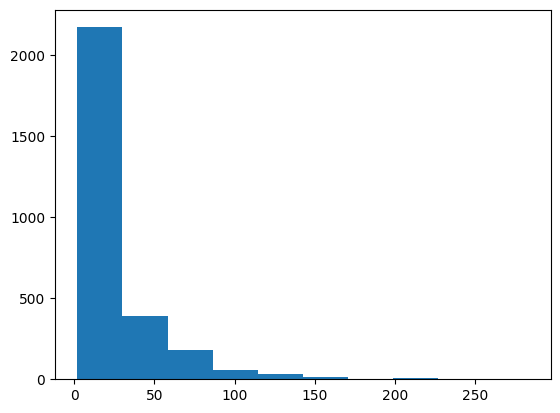

In [21]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt

# Create histogram
hist, bins, _ = plt.hist(length, bins=10)  # Adjust the number of bins as needed

# Analyze the histogram
# Identify peaks or gaps to determine the boundaries

# Choose the boundaries based on the analysis
boundaries = [ceil(bins[0])] + [ceil(bin) for bin, count in zip(bins[1:], hist) if count > 10] + [np.inf]

In [22]:
bins

array([  2. ,  30.1,  58.2,  86.3, 114.4, 142.5, 170.6, 198.7, 226.8,
       254.9, 283. ])

In [23]:
hist

array([2.171e+03, 3.910e+02, 1.800e+02, 5.900e+01, 3.000e+01, 1.400e+01,
       4.000e+00, 5.000e+00, 2.000e+00, 3.000e+00])

We trace 10 bins and if the number of sequences in a bin is higher than 10 we take the length as a boundary:

In [24]:
boundaries

[2, 31, 59, 87, 115, 143, 171, inf]

----------------------------

But considering the augmentation we can obtain more than the value that we will take because it will add modifications on the words and then it can recognize only parts of them and divide them in multiple other tokens. We will add to the max length the fifth of it. 

It is time to create our custom dataset for the t5 model. It can be also used for the Bart model.

**Notice**: The principal custom dataset is `SentenceDataset`.

Signature:
```python
class T5SentenceDataset(Dataset):

    def __init__(
        self,
        data_path: str, 
        tokenizer: PreTrainedTokenizerFast
        corpus_1: str = "french",
        corpus_2: str = "wolof",
        max_len: Union[int, None] = None,
        cp1_truncation: bool = False,
        cp2_truncation: bool = False,
        file_sep: str = ",",
        cp1_transformer: Union[TransformerSequences, None] = None,
        cp2_transformer: Union[TransformerSequences, None] = None,
        add_bos_token: bool = False,
        **kwargs):

        pass
```

In [25]:
%%writefile wolof-translate/wolof_translate/data/dataset_v4.py
from wolof_translate.utils.sent_transformers import TransformerSequences
from transformers import PreTrainedTokenizerFast
from torch.utils.data import Dataset
from typing import *
import pandas as pd
import torch
import re

class T5SentenceDataset(Dataset):

    def __init__(
        self,
        data_path: str, 
        tokenizer: PreTrainedTokenizerFast,
        corpus_1: str = "french",
        corpus_2: str = "wolof",
        max_len: Union[int, None] = None,
        truncation: bool = False,
        file_sep: str = ",",
        cp1_transformer: Union[TransformerSequences, None] = None,
        cp2_transformer: Union[TransformerSequences, None] = None,
        add_bos_token: bool = False,
        **kwargs):
        
        # let us recuperate the data frame
        self.__sentences = pd.read_csv(data_path, sep=file_sep, **kwargs)
        
        # let us recuperate the tokenizer
        self.tokenizer = tokenizer
        
        # recuperate the first corpus' sentences
        self.sentences_1 = self.__sentences[corpus_1].to_list()
        
        # recuperate the second corpus' sentences
        self.sentences_2 = self.__sentences[corpus_2].to_list()
        
        # recuperate the length
        self.length = len(self.sentences_1)
        
        # let us recuperate the max len
        self.max_len = max_len + max_len // 5 if not max_len is None else None
        
        # let us recuperate the truncation argument
        self.truncation = truncation
        
        # let us initialize the transformer
        self.cp1_transformer = cp1_transformer
        
        self.cp2_transformer = cp2_transformer
        
        # see if we add a beginning of the sentence
        self.add_bos = add_bos_token
        
        # let us recuperate the special tokens
        self.special_tokens = tokenizer.convert_ids_to_tokens(tokenizer.all_special_ids)
        
    def __getitem__(self, index):
        """Recuperate ids and attention masks of sentences at index

        Args:
            index (int): The index of the sentences to recuperate

        Returns:
            tuple: The `sentence to translate' ids`, `the attention mask of the sentence to translate`
            `the labels' ids`
        """
        sentence_1 = self.sentences_1[index]
        
        sentence_2 = self.sentences_2[index]
        
        # apply transformers if necessary
        if not self.cp1_transformer is None:
            
            sentence_1 = self.cp1_transformer(sentence_1)[0]
        
        if not self.cp2_transformer is None:
            
            sentence_2 = self.cp2_transformer(sentence_2)[0]
        
        sentence_1 = sentence_1 + self.tokenizer.eos_token
        
        sentence_2 = sentence_2 + self.tokenizer.eos_token
        
        # let us encode the sentences (we provide the second sentence as labels to the tokenizer)
        data = self.tokenizer(
            sentence_1,
            truncation=self.truncation,
            max_length=self.max_len, 
            padding='max_length', 
            return_tensors="pt",
            text_target=sentence_2)
        
        return data.input_ids.squeeze(0), data.attention_mask.squeeze(0), data.labels.squeeze(0)
        
    def __len__(self):
        
        return self.length
    
    def decode(self, labels: torch.Tensor):
        
        if labels.ndim < 2:
            
            labels = labels.unsqueeze(0)

        sentences = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        return [re.sub('|'.join(self.special_tokens), '', sentence) for sentence in sentences]


class SentenceDataset(T5SentenceDataset):

    def __init__(
        self,
        data_path: str, 
        tokenizer: PreTrainedTokenizerFast,
        corpus_1: str = "french",
        corpus_2: str = "wolof",
        max_len: Union[int, None] = None,
        truncation: bool = False,
        file_sep: str = ",",
        cp1_transformer: Union[TransformerSequences, None] = None,
        cp2_transformer: Union[TransformerSequences, None] = None,
        add_bos_token: bool = False,
        **kwargs):
        
        super().__init__(data_path, 
                        tokenizer,
                        corpus_1,
                        corpus_2,
                        max_len,
                        truncation,
                        file_sep,
                        cp1_transformer,
                        cp2_transformer,
                        add_bos_token,
                        **kwargs)
        
    def __getitem__(self, index):
        """Recuperate ids and attention masks of sentences at index

        Args:
            index (int): The index of the sentences to recuperate

        Returns:
            tuple: The `sentence to translate' ids`, `the attention mask of the sentence to translate`
            `the labels' ids`
        """
        sentence_1 = self.sentences_1[index]
        
        sentence_2 = self.sentences_2[index]
        
        # apply transformers if necessary
        if not self.cp1_transformer is None:
            
            sentence_1 = self.cp1_transformer(sentence_1)[0] 
        
        if not self.cp2_transformer is None:
            
            sentence_2 = self.cp2_transformer(sentence_2)[0]
        
        # initialize the bos token
        bos_token = '' if not self.add_bos else self.tokenizer.bos_token
        
        sentence_1 = sentence_1 
        
        sentence_2 = sentence_2
        
        # let us encode the sentences (we provide the second sentence as labels to the tokenizer)
        data = self.tokenizer(
            sentence_1,
            truncation=self.truncation,
            max_length=self.max_len, 
            padding='max_length' if not self.max_len is None else False, 
            return_tensors="pt")
        
        # let us encode the sentences (we provide the second sentence as labels to the tokenizer)
        labels = self.tokenizer(
            sentence_2,
            truncation=self.truncation,
            max_length=self.max_len, 
            padding='max_length' if not self.max_len is None else False, 
            return_tensors="pt")
        
        return (data.input_ids.squeeze(0),
                data.attention_mask.squeeze(0), 
                labels.input_ids.squeeze(0),
                labels.attention_mask.squeeze(0))
    

Overwriting wolof-translate/wolof_translate/data/dataset_v4.py


In [26]:
%run wolof-translate/wolof_translate/data/dataset_v4.py

Let us generate some data with their masks and decode the labels.

**Note that we will use, when training the `T5 model`, train and test sets and not directly the full dataset**

In [27]:
# t5_tokenizer = T5TokenizerFast.from_pretrained("t5-small")

# wrapped_tokenizer1.eos_token_id = t5_tokenizer.eos_token_id

# wrapped_tokenizer1.pad_token_id = t5_tokenizer.pad_token_id

# wrapped_tokenizer1.unk_token_id = t5_tokenizer.unk_token_id

In [28]:
# Initialize our custom dataset
dataset = SentenceDataset("data/extractions/new_data/corpora_v6.csv", wrapped_tokenizer1, truncation=True, max_len = 15)

In [29]:
generator = torch.manual_seed(5)
input_ids, input_mask, labels, _ = next(iter(DataLoader(dataset, 10, shuffle=True, generator=generator))) # generate 10 sentences with shuffling

Let us print the input ids.

In [30]:
input_ids

tensor([[1164,  192,    4,  100,    6,   73, 1076,   20,   14, 1327,    4,  100,
            6,   73, 6891,  120,  714,    1],
        [ 161,  216, 5371,   36,    9,    8, 6563,   40,  232,  132,   56,   15,
          996,    4,  105,  106,   64,    1],
        [ 430,  136,   12,  242,    4,  551,  156,    4,   19,  181,  136,   12,
          116,   33,   86,   44,   22,    1],
        [  50,    6,   32,    9, 1215,   25,   15, 3780,  105,  106,   21,   17,
            6,  354,    5,    1,    0,    0],
        [  79,    6,   73,   89,  794,    7,   24,    6, 1127,    5,    1,    0,
            0,    0,    0,    0,    0,    0],
        [  91,  529,   46,    6,   60,   33, 1081,   44,   16,    1,    0,    0,
            0,    0,    0,    0,    0,    0],
        [  76,    6,  327,    4,  189,   25,   45, 1185,   16,    1,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 570,   12,  242,   86,   23,  640,   25,   86, 1845,    7,   68,   77,
         2820,   35,    5,  16

In [31]:
input_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [32]:
labels

tensor([[ 583,  193, 1017,   63,  657,    4, 6757, 6343,   78,   13, 2116,   26,
          603,   62,   35,  227,   15,    1],
        [2356,   34,  712,    4,  278,   34,  119, 2591,    4, 4208,   14,    4,
          709,   31,   38,  503,  422,    1],
        [ 734,  920,  308,  446, 2714,  157, 1174,  112,    5,    1,    0,    0,
            0,    0,    0,    0,    0,    0],
        [1214,    9,  119, 4216,   14,  133,    5,    1,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 126,   63,   97,   29, 2088,    5,    1,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 337,  152,    4,  918,   63,   16,    1,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 748,    4,  220,  152,   16,    1,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 508,    4,   57,  118,  320,   49,  442,   39, 2170,    5,   79, 2704,
           43,   97,   48,   6

Let us decode the labels.

In [33]:
dataset.decode(labels)

['Man it jënd naa gaal, ŋarale samay baaraami tànk ngir gën a',
 'At ma Niseryaa, réew ma Baay dëkkoon, tojee, Móris ni ko ginnaaw jot',
 'Waa jii ag waa joojale duñu benn.',
 'Guwiyaan la Baay waajale Afrig.',
 'Gis naa nagu Tugël.',
 'Du ñëw, defe naa!',
 'Keneen, ki ñëw!',
 'Lii, ay nit lañu yu génn di ñaxtu. Jëm yi nag ñu ngi sol',
 'Jënd ñaa menn xar mi!',
 'Dafa di dem.']